# Analyzing @netanyahu Tweets using Time series & NLP techniques 

**By Ori Rosenthal**<br> 
[LinkedIn](https://www.linkedin.com/in/ori-rosenthal-395bb859/) :
[Website](https://orosenthal.pythonanywhere.com/)
<img src="tweet_logo.png" alt="Drawing" style="width: 150px;"/>

This is a summary notebook of a more comprehensive study I conducted on Prime Minister Benjamin Netanyahu's tweets.  
You can see more analytics, code, visualization, and other features in the main notebook at the following link **[Link](https://nbviewer.jupyter.org/github/Orosenthal/PM-tweets-analysis/blob/main/PM%20tweets%20analysis.ipynb)

## In Israel, four rounds of Knesset elections have been held in the last two years.<br>Social media is one of the primary channels by which the Prime Minister<br> communicates with the general public.<br><br>Benjamin Netanyahu has about 1.8 million followers on Twitter.<br><br>The primary aim of the research was to look for behavioral patterns<br> and trends in the prime minister's tweets during the time before the elections.<br>Examine the number of tweets, the emotional content of them,<br> and the topics on which the prime minister tweets.

* **The research was limited to Benjamin Netanyahu's tweets in Hebrew,  
which account for roughly 72 percent of all his tweets.**


In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from wordcloud import WordCloud
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
from gsdmm import MovieGroupProcess
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# load preprocessed data (All the preprocessing can be seen in the main notebook, which can be accessed via the link above.)
df = pd.read_pickle('df_pm.pkl')
df = df[df.language =='iw'].copy() # only Hebrew tweets

The average number of tweets per month in the three months preceding the election of 2015-03-17:  81
The average number of tweets per month in the three months preceding the election of 2019-04-09:  121
The average number of tweets per month in the three months preceding the election of 2019-09-17:  130
The average number of tweets per month in the three months preceding the election of 2020-03-02:  137
The average number of tweets per month in the three months preceding the election of 2021-03-23:  178

When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is: 32


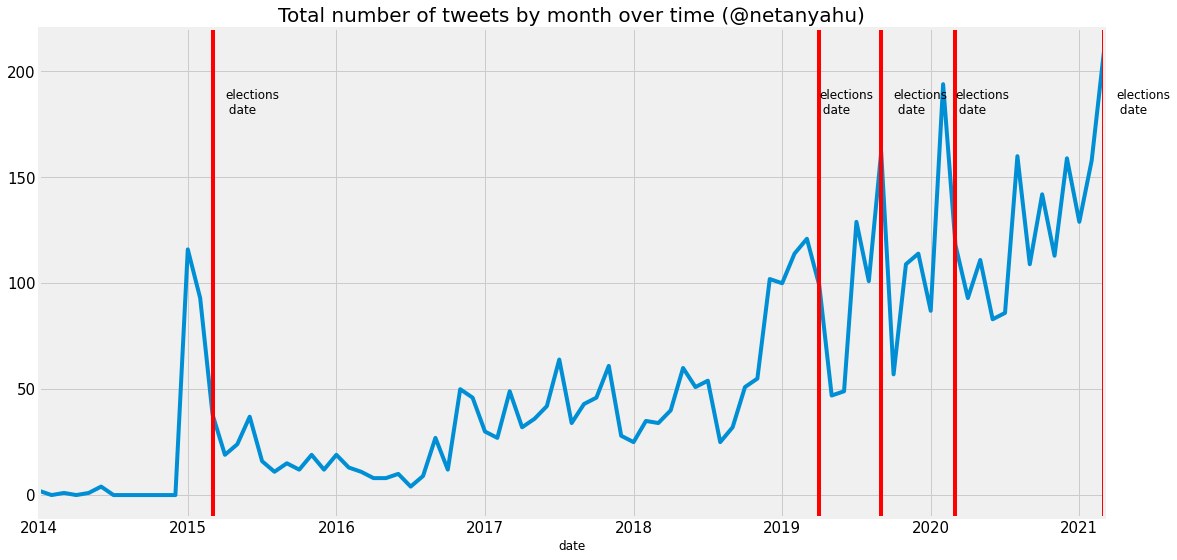

In [3]:
# calculating and plotting tweets by time series vs election dates. monthly agg. 
# Using the previous five voting dates (4 in the last two years and one before in 2015)
election_dates = ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02','2021-03-23']
three_month_bfore_election =[str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=90)) for i in election_dates]
time_range_b4_elections = list(zip(three_month_bfore_election,election_dates))

df['2014':].resample('M')['tweet'].count().plot(figsize=(17,9),y="");plt.xticks(size=15);plt.yticks(size=15);
plt.title("Total number of tweets by month over time (@netanyahu)",size=20);
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'elections\n date',size=12)
for i in time_range_b4_elections:
    print(f"The average number of tweets per month in the three months preceding the election of {i[1]}: "\
          ,round(df[i[0]:i[1]].tweet.count()/3))
print()
print('When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is:',
      round(df['2015-04':'2018-12-31'].groupby(pd.Grouper(freq='M'))['tweet'].count().mean()))

**The number of tweets rises dramatically before each election day, as can be seen.**

Elections Dates:  ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02', '2021-03-23']


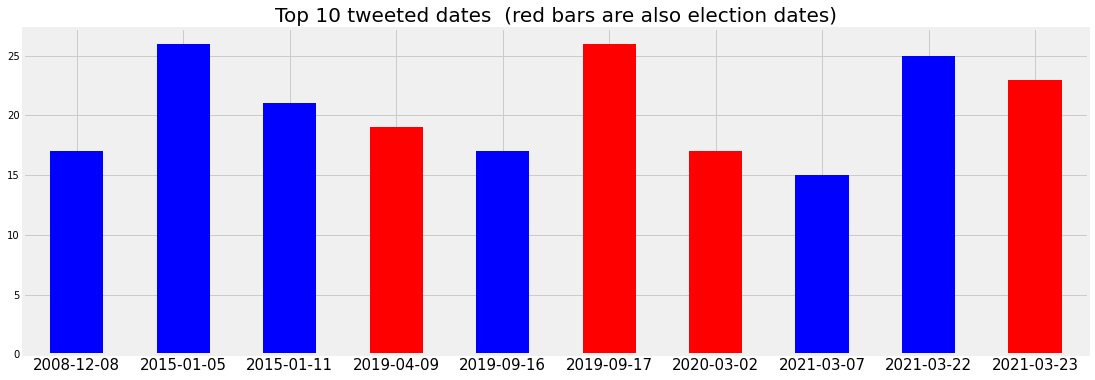

In [4]:
print('Elections Dates: ' ,election_dates)
plt.rcParams['patch.edgecolor'] = 'black'
top_dates = df.date.index.strftime('%Y-%m-%d').value_counts().head(10).to_frame('tweets_count').sort_index()
top_dates.tweets_count.plot(kind='bar',figsize=(17,6),color=['r' if x in(election_dates) else 'b'for x in top_dates.index]);
plt.title("Top 10 tweeted dates  (red bars are also election dates)", size=20); plt.xticks(size=15,rotation=0);

### ** As can be seen, four out of the five election days are also among the <u>top tweeted dates</u>.

In [5]:
df_tm = pd.read_pickle('df_tm.pkl')

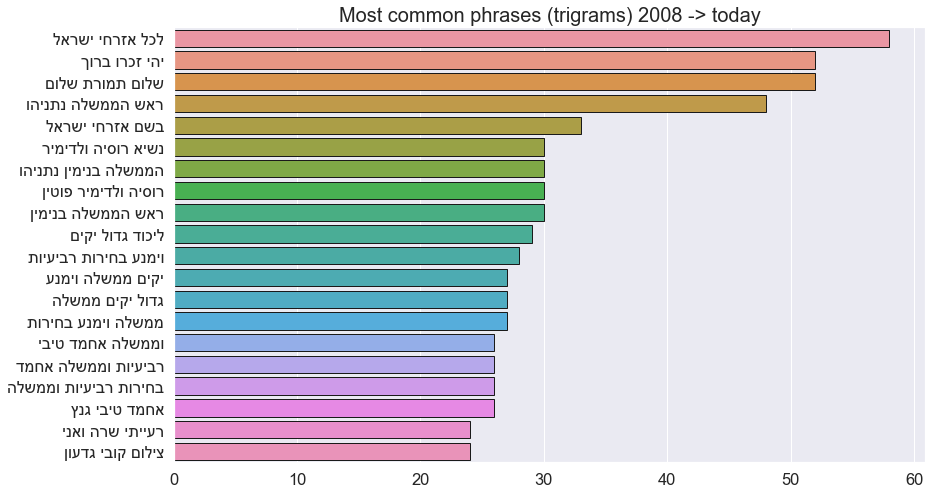

In [6]:
# importing Hebrew stop words.
with open('he_stop_words.txt', "r") as f:
    he_s_words = f.readline().split(',')
he_s_words = [i.strip() for i in he_s_words]

top=20
firstword=""
c=CountVectorizer(stop_words=he_s_words,ngram_range=(3,3))
X=c.fit_transform(df_tm['clean_tweet'].tolist())
words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
res=words[words['index'].apply(lambda x: firstword in x)].head(top)
terms = [get_display(x) for x in res['index']]; plt.figure(figsize=(12,8));sns.set(font_scale = 1.5);
sns.barplot(x=res[0], y=terms,edgecolor='k'); 
plt.title('Most common phrases (trigrams) 2008 -> today', size=20); plt.xlabel("");

## <u>Word Cloud</u> 
* (Text data visualization. Displays a list of words with varying sizes to reflect their significance).

### What words did Benjamin Netanyahu used the most in his tweets <u>within the three months leading up to the four most recent elections</u>? 

In [7]:
# finding top words (lemmas) in all tweets 
flat_words = [item for sublist in df_tm['lemma_text'] for item in sublist]
word_freq = FreqDist(flat_words).most_common(20)
words_to_extract = [word[0] for word in word_freq if word[1] >500] # eliminate words that repeats themselves over 500 times 
print(word_freq)

[('ישראל', 2247), ('כול', 1314), ('ממשלה', 1067), ('מדינה', 925), ('ראש', 553), ('אזרח', 511), ('המשיך', 474), ('יום', 435), ('שלום', 430), ('ליכוד', 412), ('עולם', 401), ('שנה', 373), ('ביטחון', 322), ('נשיא', 320), ('רב', 317), ('קורונה', 317), ('יחד', 308), ('גדול', 291), ('בן', 289), ('חיים', 288)]


In [8]:
def word_cloud(text):
    
    twitter_mask = imageio.imread('./twitter_mask.png')
    wordcloud = WordCloud(width=800, height=500, stopwords = he_s_words,
                          font_path = 'C:\Windows\Fonts\courbd.ttf',random_state=10,
                          background_color='whitesmoke',max_words=50,contour_color='blue',
                          colormap='ocean',collocations=False, contour_width=0.15,
                          min_font_size= 10).generate(get_display(text))
    
    return wordcloud

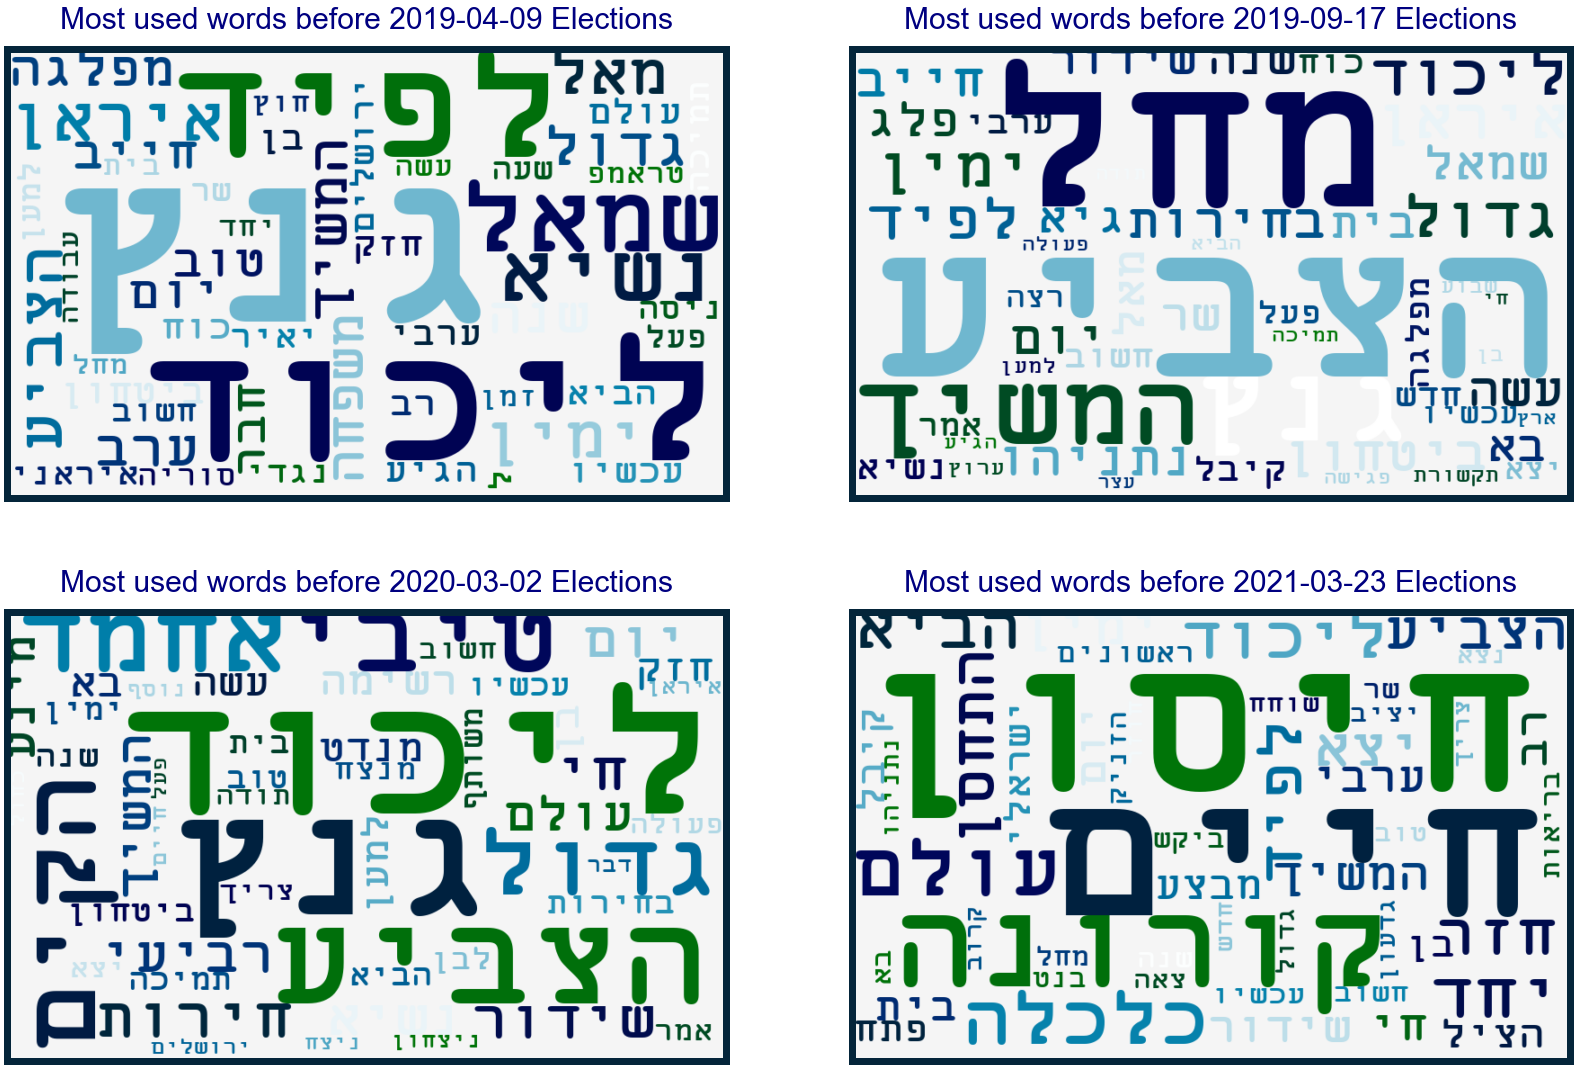

In [9]:
import imageio
fig = plt.figure(figsize=(23,23))

for index, i in enumerate(time_range_b4_elections[1:]):
    temp = " ".join([i for sublist in df_tm.loc[i[0]:i[1],'lemma_text']\
                     for i in sublist if i is not None if i not in words_to_extract])
    ax = fig.add_subplot(3, 2, index+1);
    plt.imshow(word_cloud(temp),interpolation='bilinear')
    for axis in ['top','bottom','left','right']:
        plt.gca().spines[axis].set_color('#04253a')
        plt.gca().spines[axis].set_linewidth(7)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.grid(False)
    plt.tight_layout(h_pad=4, w_pad=4);
    plt.title(f"Most used words before {i[1]} Elections",\
              size=30, color='navy',pad=20);
      

### Words Timeline Occurrences

I wanted to see how words emerge and change in Benjamin Netanyahu's tweets over time, so I created a function that tests when a word appears in tweets, counts the amount of occurrences, and normalizes them to the number of quarterly tweets in order to determine their relative significance.I narrowed the search to 2015 and later, both because it seems that the popularity of usage (as measured by the number of tweets) has grown since then, and because I wanted to review more specific words and events like elections.

In [10]:
# plt.rcParams.update(plt.rcParamsDefault)
def words_over_time(*argv):
    """
    Return timeline bar plot of normalized words count to quarterly sum of tweets
    """
    temp_df = df['2015':][['tweet']].copy()
    for term in argv:
        temp_df[term] = np.where(temp_df.tweet.str.contains(term),1,0)
    temp_df_q = round((temp_df.resample('Q').sum()/temp_df.resample('Q').count()*100),1).fillna(0)
    temp_df_q.index = temp_df_q.index.strftime('%Y-%m')
    temp_df_q = temp_df_q.T[1:]
    temp_df_q.T.plot(kind='bar',width=0.8, figsize=(18,6));
    lgd = [get_display(x) for x in temp_df_q.index]
    plt.legend(lgd,loc='upper left',fontsize=15);ax = plt.axes();
    ax.set_title('Words timeline as a percentage of quarterly tweets', fontsize=20)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter()) 

**Examples:**

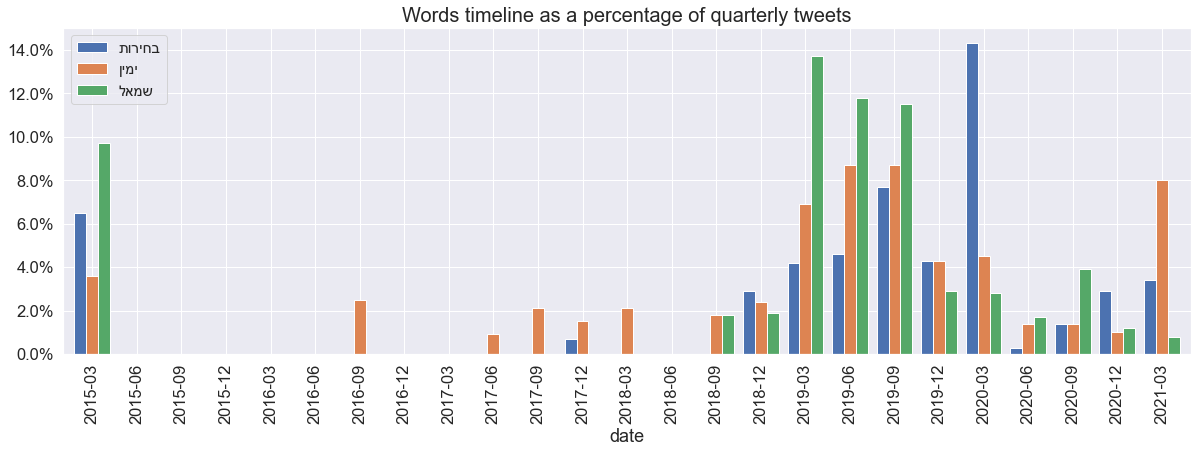

In [11]:
words_over_time('בחירות','שמאל','ימין')

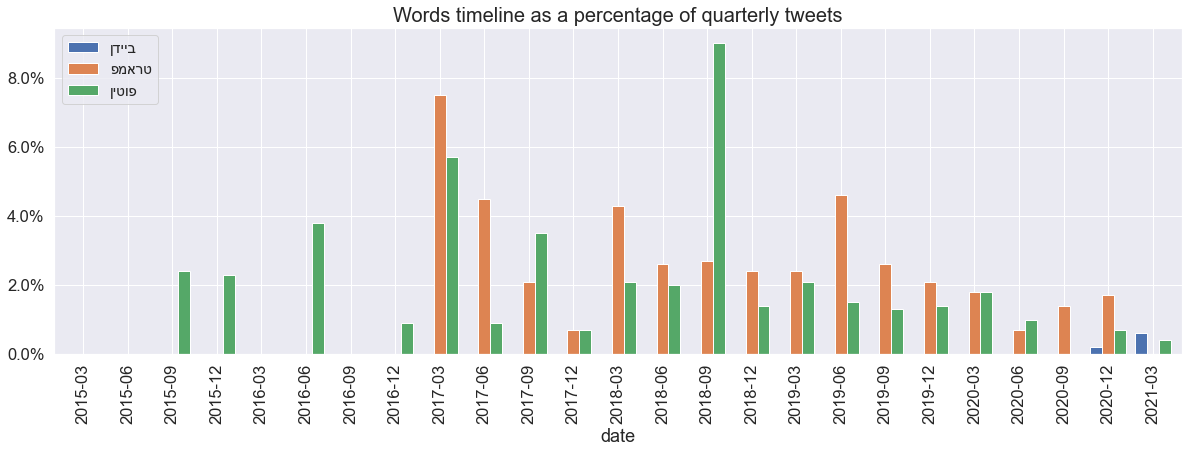

In [12]:
words_over_time('ביידן','טראמפ','פוטין')

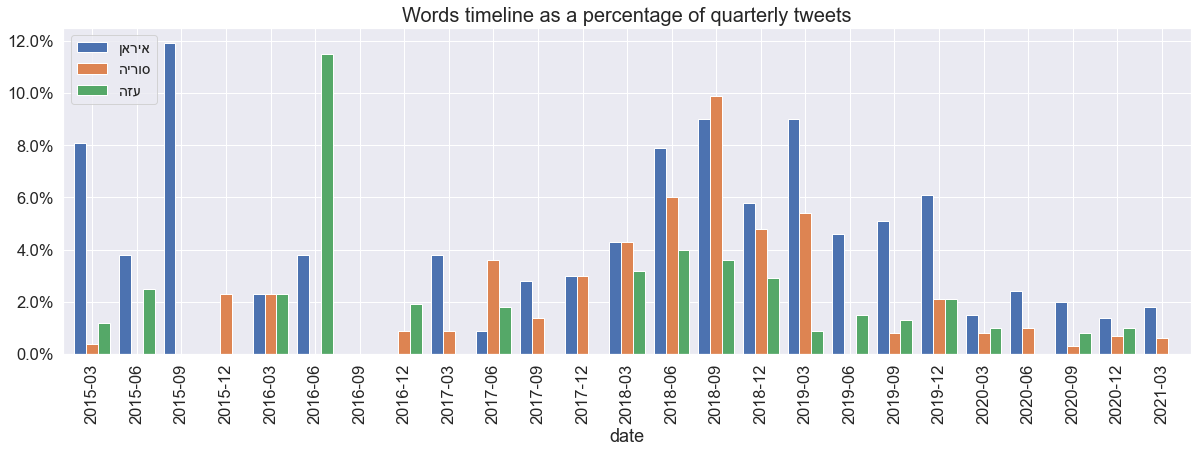

In [13]:
words_over_time('איראן','סוריה','עזה')

## <u>Sentiment Analysis with HeBERT</u>   
HeBERT is a Hebrew pretrained language model. It is based on Google's BERT architecture and it is BERT-Base config **[Link](https://github.com/avichaychriqui/HeBERT)

In [14]:
# Load the dataset
df_heBert = pd.read_pickle('df_heBert.pkl')

In [15]:
def sentiment_plot(since='2019', time='M'):
    
    strftime_c = '%Y-%m' if time=='M' else '%Y-%m-%d'
    if time =='M':
        df_since2019 = df_heBert[since:].groupby('s_heBert_label').resample(time).size().T
        df_since2019.index = df_since2019.index.strftime(strftime_c) 
    else:
        df_since2019 = df_heBert[since:].groupby('s_heBert_label').resample(time).size().unstack(0, fill_value=0)
        df_since2019.index = df_since2019.index.strftime(strftime_c)
        
    print('Elections Dates: ' ,election_dates[1:])
    plt.style.use('seaborn-dark')
    ax = df_since2019.plot(kind='bar',width=0.8,color=['red','grey','green'] ,figsize=(19,10));
    time_interval = 'monthly' if time=='M' else 'weekly' if time=='W' else 'daily'
    plt.title(f'Sentiment summarization of tweets since {since} on a {time_interval} basis (HeBERT model)',size=25);
    plt.legend(loc="upper left");plt.xticks(rotation=45); plt.ylabel('Number of tweets');plt.xlabel("");plt.tight_layout();

Elections Dates:  ['2019-04-09', '2019-09-17', '2020-03-02', '2021-03-23']


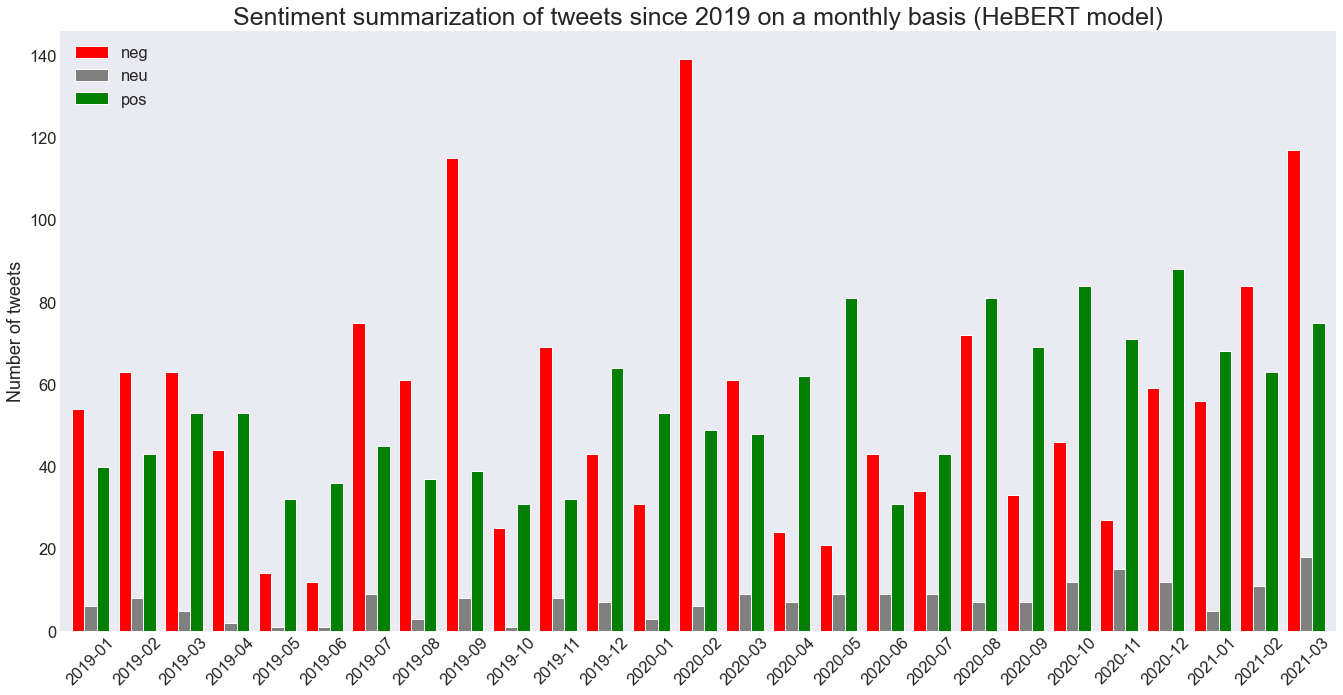

In [16]:
# Monthly since 2019
sentiment_plot('2019','M')

**We can observe the relationship between election days and negative sentiment tweets preceding them.**<br>
negative sentiment refers to a wide range of emotions that are expressed in the text, including rage, fear, urgency, concern, and more.<br>It seems that negative sentiment tweets might be useful in provoking voters to act.

Elections Dates:  ['2019-04-09', '2019-09-17', '2020-03-02', '2021-03-23']


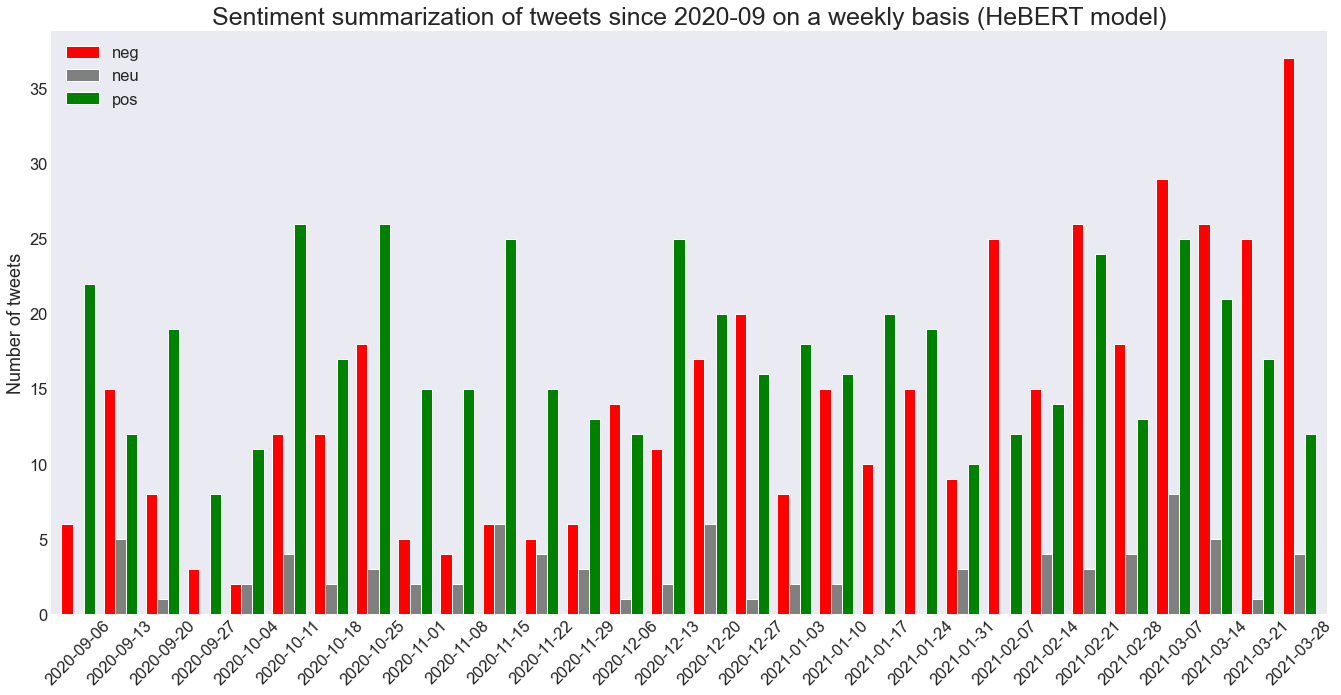

In [17]:
# Weekly since 2020-09
sentiment_plot('2020-09','W')

**On a monthly baisis, as well on a weekly basis (in example: for the last four weeks), the amount of tweets with negative sentiment has been higher than the number of tweets with positive sentiment, as seen in the graph.  
It is very interesting to see this phenomenon in light of the fact that the elections in Israel were held on March 23, 2021, and particularly when we see that in almost all the weeks preceding the last month, the positive sentiment outweighed negative sentiment.**

## <u>Topic Modeling</u>

Topic Modeling aims to find the topics (or clusters) inside a corpus of texts, without knowing those topics at first. It's an unsupervised classification technique.
I'll be using for this task:

#### Gibbs sampling algorithm for a Dirichlet Mixture Model

* Model-based clustering method for short texts.The algorithm iterating across and reassigning clusters using a conditional distribution as a basis. Documents are allocated to clusters based on the highest conditional probability, similar to how the Naive Bayes Classifier functions. It assumes that each short text is generated from single latent topic and use Gibbs sampling technique. The model claims to overcome the short text clustering sparsity problem while still displaying word topics like LDA. 

In [18]:
# Eliminate top words and words below 3 characters to try to help the algorithm refine the clustering.
df_tm['clean_lemma_text'] = df_tm['lemma_text']\
                            .apply(lambda x: [word for word in x if word not in words_to_extract and len(word)>2])

In [19]:
docs = df_tm['clean_lemma_text'].tolist()

np.random.seed(10) 
# GSDMM algorithm
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=10)

vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
n_docs = len(docs)

# Fit the model
y = mgp.fit(docs, n_terms)

In stage 0: transferred 3761 clusters with 10 clusters populated
In stage 1: transferred 2209 clusters with 10 clusters populated
In stage 2: transferred 1343 clusters with 10 clusters populated
In stage 3: transferred 910 clusters with 10 clusters populated
In stage 4: transferred 732 clusters with 10 clusters populated
In stage 5: transferred 639 clusters with 10 clusters populated
In stage 6: transferred 587 clusters with 10 clusters populated
In stage 7: transferred 491 clusters with 10 clusters populated
In stage 8: transferred 449 clusters with 10 clusters populated
In stage 9: transferred 466 clusters with 10 clusters populated


In [20]:
def top_words(distribution, top_index, num_words):
    '''
    Returns the top words in each cluster based on occources.
    '''
    for topic in top_index:
        pairs = sorted([(k, v) for k, v in distribution[topic].items()], key=lambda x: x[1], reverse=True)
        print(f"Cluster {topic} : {pairs[:num_words]}")
        print('-'*120)

In [21]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topics :', doc_count)
print('*'*70)

# Topics sorted by document inside
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*70)


# Show the top 15 words by cluster, it helps to make the topic_dict below
top_words(mgp.cluster_word_distribution, top_index, 15)

Number of documents per topics : [420 481 446 428 540 842 601 349 291 321]
**********************************************************************
Most important clusters (by number of docs inside): [5 6 4 1 2 3 0 7 9 8]
**********************************************************************
Cluster 5 : [('שלום', 239), ('קורונה', 239), ('חיסון', 192), ('עולם', 167), ('חיים', 166), ('המשיך', 154), ('כלכלה', 138), ('יחד', 133), ('הביא', 119), ('יום', 102), ('בריאות', 99), ('עסק', 97), ('קיבל', 90), ('שנה', 89), ('עשה', 88)]
------------------------------------------------------------------------------------------------------------------------
Cluster 6 : [('נשיא', 190), ('איראן', 101), ('חשוב', 86), ('טראמפ', 83), ('נתניהו', 79), ('פגישה', 72), ('פוטין', 70), ('אמריקני', 58), ('רוסיה', 57), ('שלום', 53), ('יום', 52), ('ארה"ב', 52), ('שידור', 51), ('עולם', 49), ('אמר', 46)]
----------------------------------------------------------------------------------------------------------------------

In [22]:
# created by hand so that the topic names refer to the above clusters
topic_dict = {}
topic_names = ['Health & Economy',
               'International Affairs',
               'International Affairs',
               'National Security',
               'Politics',
               'Memorials',
               'Politics',
               'Politics',
               'State security',
               'personal allegations']

for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]

In [23]:
# assign clusters into the dataframe 
df_tm['cluster_name'] = pd.Series([topic_dict[int(x)] for x in y], index=df_tm.index)
df_tm['cluster_number'] = pd.Series(y, index=df_tm.index)
df_tm['cluster_name'].value_counts()

Politics                 1215
International Affairs    1141
Health & Economy          842
National Security         481
Memorials                 428
State security            321
personal allegations      291
Name: cluster_name, dtype: int64

**The most reliable method for evaluating unsupervised topic models is still human judgement. However, this takes time and money. I had to look at a few randomly picked tweets in each cluster, much as I had to do with the topic names. 
The results are not perfect, and there might be ways to improve, but as compared to other teqniuqes I tired, GSDMM produced the best results.**

In [24]:
print('Top words related to politics:')
top_words(mgp.cluster_word_distribution, [0,2,7], 7)

Top words related to politics:
Cluster 0 : [('ליכוד', 101), ('שנה', 55), ('למען', 54), ('תמיכה', 49), ('טוב', 46), ('המשיך', 44), ('תפקיד', 42)]
------------------------------------------------------------------------------------------------------------------------
Cluster 2 : [('הצביע', 205), ('ליכוד', 192), ('לפיד', 119), ('ימין', 115), ('מחל', 92), ('גנץ', 88), ('שמאל', 68)]
------------------------------------------------------------------------------------------------------------------------
Cluster 7 : [('גנץ', 112), ('טיבי', 55), ('ליכוד', 51), ('אחמד', 50), ('הקים', 48), ('שידור', 36), ('חירות', 36)]
------------------------------------------------------------------------------------------------------------------------


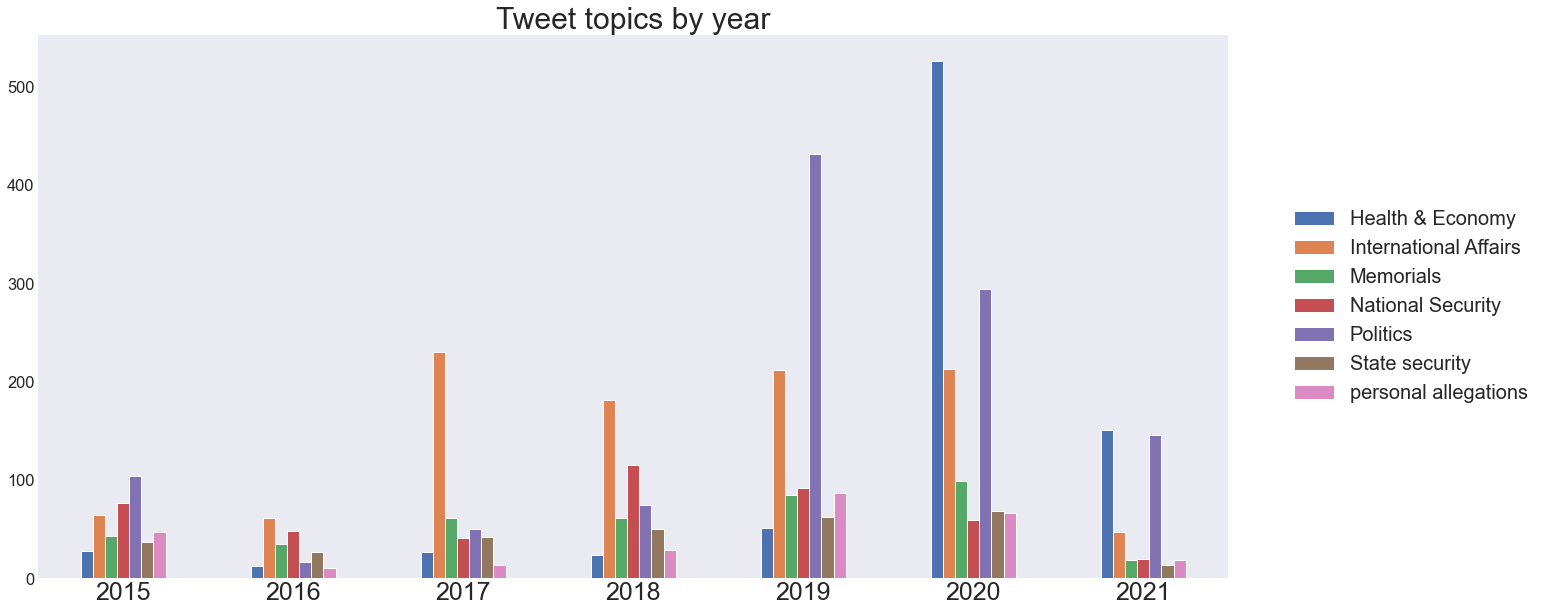

In [25]:
df_gsdmm = df_tm['2015':].resample('Y').cluster_name.value_counts().unstack().fillna(0)
df_gsdmm.index = df_gsdmm.index.strftime('%Y')
df_gsdmm.plot(kind='bar',figsize=(19,10));
plt.title(f'Tweet topics by year', size=30);plt.xlabel("")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",prop={'size': 20});plt.xticks(size=25,rotation=0);

**As can be seen in election years, the number of tweets about politics is incredibly high. It can also be seen that by 2020, the majority of tweets were in the health sector as a result of the Corona plague.**

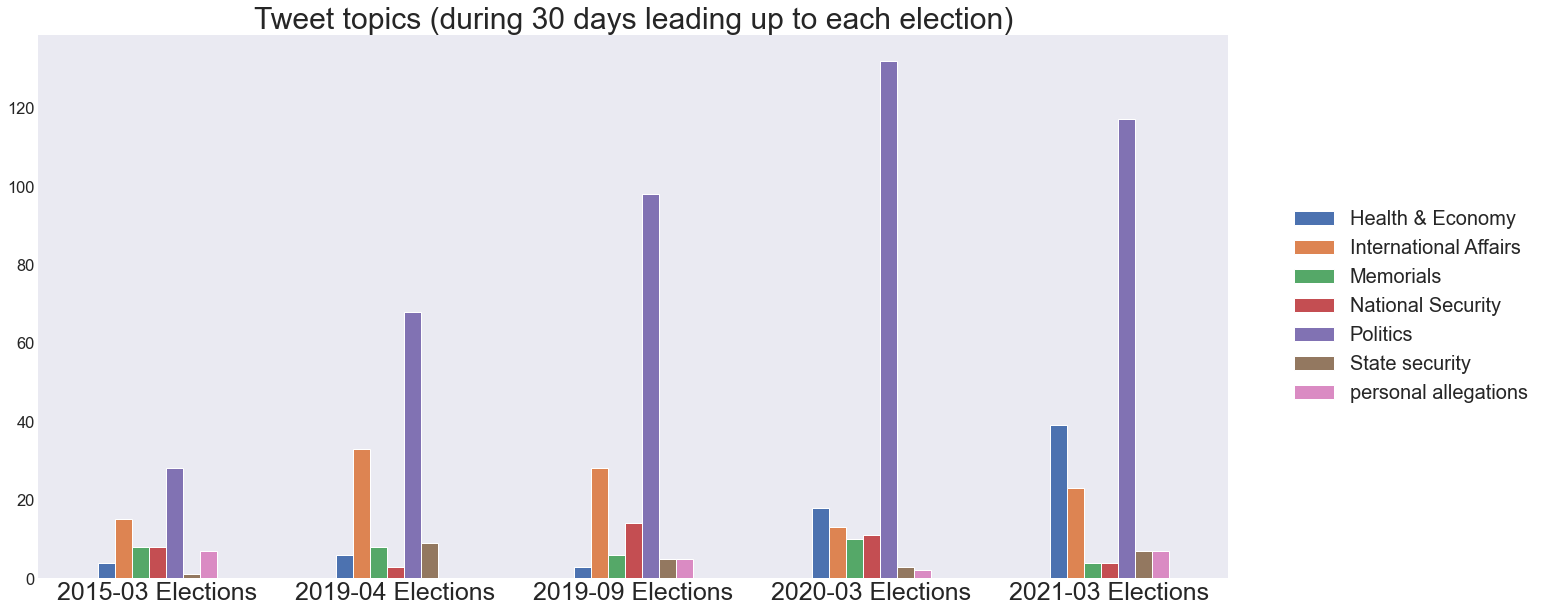

In [26]:
d = dict()
one_month_bfore_election =[str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=30)) for i in election_dates]
time_range_b4_elections_1m = list(zip(one_month_bfore_election,election_dates))

for i, index in enumerate(time_range_b4_elections_1m):
    d[f'{index[1][:-3]} Elections'] = df_tm.loc[time_range_b4_elections_1m[i][0]:time_range_b4_elections_1m[i][1]]\
    .groupby('cluster_name')[['cluster_name']].count()

df_gsdmm_1m = pd.concat(d, axis=1).fillna(0).T
df_gsdmm_1m.reset_index(level=1, drop=True, inplace=True)
df_gsdmm_1m.plot(kind='bar',figsize=(19,10));
plt.title(f'Tweet topics (during 30 days leading up to each election)', size=30);plt.xlabel("")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",prop={'size': 20});plt.xticks(size=25,rotation=0);

**As one would expect, during the thirty days before each election,<br>
the tweets are almost entirely dedicated to dealing with the general election.**